# LSTM Time Series Example

This tutorial is based on [Time Series Forecasting with the Long Short-Term Memory Network in Python](http://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/) by Jason Brownlee.


## Part 1 - Data Prep

Before we get into the example, lets look at some visitor data from Yellowstone National park.

month
1979-01-01     23605
1979-02-01     31992
1979-03-01     17813
1979-04-01     34095
1979-05-01    108952
Name: visitors, dtype: int64


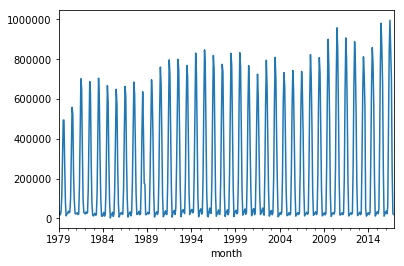

In [1]:
# load and plot dataset
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
# load dataset
def parser(x):
    return datetime.strptime(x, '%Y-%m-%d')
series = read_csv('../data/yellowstone-visitors.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# summarize first few rows
print(series.head())
# line plot
series.plot()
pyplot.show()

The park's recreational visits are highly seasonable with peak season in June.  The park tracks monthly averages from the last four years on it [web site](https://www.nps.gov/yell/planyourvisit/visitationstats.htm).  A simple approach to predict the next years visitors, is to use these averages.

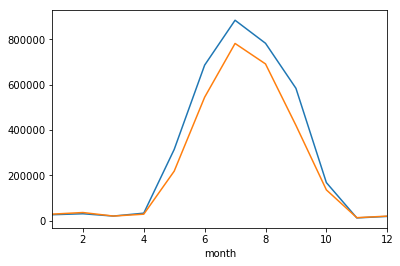

In [2]:
prev_4_years = series[-60:-12]
last_year = series[12:]

pred = prev_4_years.groupby(by=prev_4_years.index.month).mean()
pred.plot()

act = last_year.groupby(by=last_year.index.month).mean()
act.plot()

pyplot.show()

In [3]:
from math import sqrt
from sklearn.metrics import mean_squared_error

rmse = sqrt(mean_squared_error(act, pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 79584.318


In [4]:
from pandas import Series

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# transform to be stationary
differenced = difference(series, 1)
print(differenced.head())

0      8387
1    -14179
2     16282
3     74857
4    204972
dtype: int64


In [5]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# invert transform
inverted = list()
for i in range(len(differenced)):
    value = inverse_difference(series, differenced[i], len(series)-i)
    inverted.append(value)
inverted = Series(inverted)
print(inverted.head())

0     31992
1     17813
2     34095
3    108952
4    313924
dtype: int64


### Scaled Dataset

Scale the labels to fit between -1 and 1.

In [6]:
from sklearn.preprocessing import MinMaxScaler
# transform scale
X = series.values
X = X.reshape(len(X), 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(X)
scaled_X = scaler.transform(X)
scaled_series = Series(scaled_X[:, 0])
print(scaled_series.head())

0   -0.957063
1   -0.940182
2   -0.968721
3   -0.935949
4   -0.785277
dtype: float64


/Users/johnhudzina/anaconda/envs/keras-tutorial/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [7]:
# invert transform
inverted_X = scaler.inverse_transform(scaled_X)
inverted_series = Series(inverted_X[:, 0])
print(inverted_series.head())

0     23605.0
1     31992.0
2     17813.0
3     34095.0
4    108952.0
dtype: float64
